In [1]:
# this code analyses and predicts the chiller performance ['total_kW'] based on ['amb_temp','run_sts','vsd_freq','total_kW','pp*_FB','sup_temp','ret_temp']

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pymssql
# import pyodbc  as pdc
import sqlalchemy as sa

import urllib.parse

import re
import tqdm
import os


import warnings
warnings.filterwarnings('ignore')


server='40.123.229.239'
username='smartae'
password = os.getenv('SQL_PASSWORD')
database='master'
encoded_password = urllib.parse.quote_plus(password)

conn = pymssql.connect(server, username, password, "master")
cursor = conn.cursor(as_dict=True)



In [3]:
df=pd.read_csv('../SQLMasterMetaData2.csv').drop(['Unnamed: 0'],axis=1)
df[df['TABLE_NAME'].str.contains('R320')].TABLE_NAME.values

parameters={'amb_temp1': 'R320_2_CH1_AMB_TEMP', 'run_sts': 'R320_1_CH1_RUN_STS', 'vsd_freq': 'R320_2_CH1_VSD_OUTFREQ',
          'total_kW': 'R320_2_CH1_METER_TOTAL_ACTIVE_POWER',
          'pp1': 'R320_1_PP1_FB', 'pp2': 'R320_1_PP2_FB', 'pp3': 'R320_1_PP3_FB', 'pp4': 'R320_1_PP4_FB',
          'pp5': 'R320_1_PP5_FB', 'pp6': 'R320_1_PP6_FB', 'pp7': 'R320_1_PP7_FB', 'pp8': 'R320_1_PP8_FB',
          'sup_temp': 'R320_2_CH1_SUP_WTRTEMP', 'ret_temp': 'R320_2_CH1_RET_WTRTEMP', 'ch4_total_kW': 'R320_2_CH4_METER_TOTAL_ACTIVE_POWER',
          'ch2_kW1': 'R320_2_CH2A_METER_Total_Active_power', 'ch2_kW2': 'R320_2_CH2B_METER_Total_Active_power',
          'ch3_kW1': 'R320_2_CH3A_METER_Total_Active_power', 'ch3_kW2': 'R320_2_CH3B_METER_Total_Active_power'}

ch_parms=list(parameters.values())
labels=list(parameters.keys())



In [4]:
ignored=[]
res=pd.DataFrame()
for i,point in enumerate(ch_parms[:]):
        
        # point=rtus[3]
        query1=f"""SELECT 
                Timestamp,[VALUE] as {labels[i]}
                FROM [niagara].[dbo].{point}
                where timestamp < '2023-09-01'"""
        # print(query1)
        # cursor.execute(query1)
        # tempdf=pd.DataFrame(cursor.fetchall())
        tempdf=pd.read_sql(query1,conn)
        if len(tempdf)<10000:
            print(point,'==> IGNORED!!!')
            ignored.append(point)
            continue
        tempdf=tempdf.groupby(pd.Grouper(key='Timestamp',freq='15min')).mean().round(2).dropna()
        res=res.join(tempdf,how='outer')
res['run_sts']=res.run_sts.fillna(method='ffill')
res['run_sts']=res.run_sts.fillna(method='bfill')

res


,amb_temp1,run_sts,vsd_freq,total_kW,pp1,pp2,pp3,pp4,pp5,pp6,pp7,pp8,sup_temp,ret_temp,ch4_total_kW,ch2_kW1,ch2_kW2,ch3_kW1,ch3_kW2
Timestamp,,,,,,,,,,,,,,,,,,,
2019-09-17 15:00:00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.33,NaN,NaN,NaN,NaN,NaN
2019-09-17 15:15:00,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.33,NaN,NaN,NaN,NaN,NaN
2019-09-17 15:30:00,37.44,1.0,137.3,NaN,100.0,100.00,100.00,100.00,100.00,0.11,0.59,100.00,5.56,10.22,NaN,NaN,NaN,NaN,NaN
2019-09-17 15:45:00,37.39,1.0,137.3,0.14,100.0,100.00,100.00,100.00,100.00,0.10,0.60,100.00,5.61,10.28,0.12,0.68,0.66,0.68,0.00
2019-09-17 16:00:00,36.89,1.0,137.3,0.14,100.0,100.00,100.00,100.00,100.00,0.12,0.61,100.00,5.67,10.33,0.12,0.68,0.66,0.68,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 22:45:00,35.79,1.0,91.7,86.46,0.9,79.69,79.63,79.65,79.79,79.62,79.64,0.84,7.11,11.86,86.65,0.66,0.65,0.66,0.64
2023-08-31 23:00:00,35.73,1.0,99.3,94.22,0.9,77.66,77.61,77.60,77.76,77.59,77.62,0.84,7.01,12.03,88.90,0.66,0.65,0.67,0.64
2023-08-31 23:15:00,35.37,1.0,94.5,85.94,0.9,74.64,74.58,73.55,74.74,74.54,74.59,0.84,7.06,11.99,88.00,0.67,0.65,0.67,0.64


In [5]:
# which method of approximation is the most accurate
d1=res.copy()

# optimized temp 1 (ch1,4, RTU ML) 15 mins
temp=pd.read_pickle('ambtemp.pkl')
temp.index=pd.to_datetime(temp.index)
d1['amb_temp']=temp
d1['run_sts_rounded']=d1['run_sts'].round()
d1['run_sts_p1rounded']=(d1['run_sts']+.1).round()
d1=d1[~d1['total_kW'].isna()]

d1['ch2kw']=d1.ch2_kW1+d1.ch2_kW2
d1['ch3kw']=d1.ch3_kW1+d1.ch3_kW2
d1['ch1_run_sts']=d1.total_kW.apply(lambda x: 1 if x>10 else 0)
d1['ch2_run_sts']=d1.ch2kw.apply(lambda x: 1 if x>10 else 0)
d1['ch3_run_sts']=d1.ch3kw.apply(lambda x: 1 if x>10 else 0)
d1['ch4_run_sts']=d1.ch4_total_kW.apply(lambda x: 1 if x>10 else 0)
d1['NR_ch']=d1.ch1_run_sts+d1.ch2_run_sts+d1.ch3_run_sts+d1.ch4_run_sts
d1['fper_ch']=d1.apply(lambda x: 0 if x.NR_ch==0 else (x.pp1+x.pp2+x.pp3+x.pp4+x.pp5+x.pp6+x.pp7+x.pp8)/x.NR_ch,axis=1)
d1=d1[~d1.fper_ch.isna()]
d1['dT']=d1.apply(lambda x: max(0,x.ret_temp-x.sup_temp),axis=1)
runs=[i for i in d1.columns if 'run' in i.lower()]
runs=[ 'run_sts_p1rounded', 'ch1_run_sts']





In [6]:

# d1.index
# temp.index
d1['t']=temp
d1


,amb_temp1,run_sts,vsd_freq,total_kW,pp1,pp2,pp3,pp4,pp5,pp6,...,ch2kw,ch3kw,ch1_run_sts,ch2_run_sts,ch3_run_sts,ch4_run_sts,NR_ch,fper_ch,dT,t
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-17 15:45:00,37.39,1.0,137.3,0.14,100.0,100.00,100.00,100.00,100.00,0.10,...,1.34,0.68,0,0,0,0,0,0.000,4.67,NaN
2019-09-17 16:00:00,36.89,1.0,137.3,0.14,100.0,100.00,100.00,100.00,100.00,0.12,...,1.34,0.68,0,0,0,0,0,0.000,4.66,36.160000
2019-09-17 16:15:00,36.28,1.0,140.0,0.14,100.0,100.00,100.00,100.00,100.00,0.12,...,1.34,0.68,0,0,0,0,0,0.000,4.72,NaN
2019-09-17 16:30:00,36.33,1.0,139.7,0.14,100.0,100.00,100.00,100.00,100.00,0.10,...,1.34,0.68,0,0,0,0,0,0.000,4.78,NaN
2019-09-17 16:45:00,35.72,1.0,138.1,0.14,100.0,100.00,100.00,100.00,100.00,0.10,...,1.34,0.68,0,0,0,0,0,0.000,4.77,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 22:45:00,35.79,1.0,91.7,86.46,0.9,79.69,79.63,79.65,79.79,79.62,...,1.31,1.30,1,0,0,1,2,239.880,4.75,NaN
2023-08-31 23:00:00,35.73,1.0,99.3,94.22,0.9,77.66,77.61,77.60,77.76,77.59,...,1.31,1.31,1,0,0,1,2,233.790,5.02,33.736667
2023-08-31 23:15:00,35.37,1.0,94.5,85.94,0.9,74.64,74.58,73.55,74.74,74.54,...,1.32,1.31,1,0,0,1,2,224.190,4.93,NaN


### Main Changes

<AxesSubplot: xlabel='cload_%', ylabel='Count'>

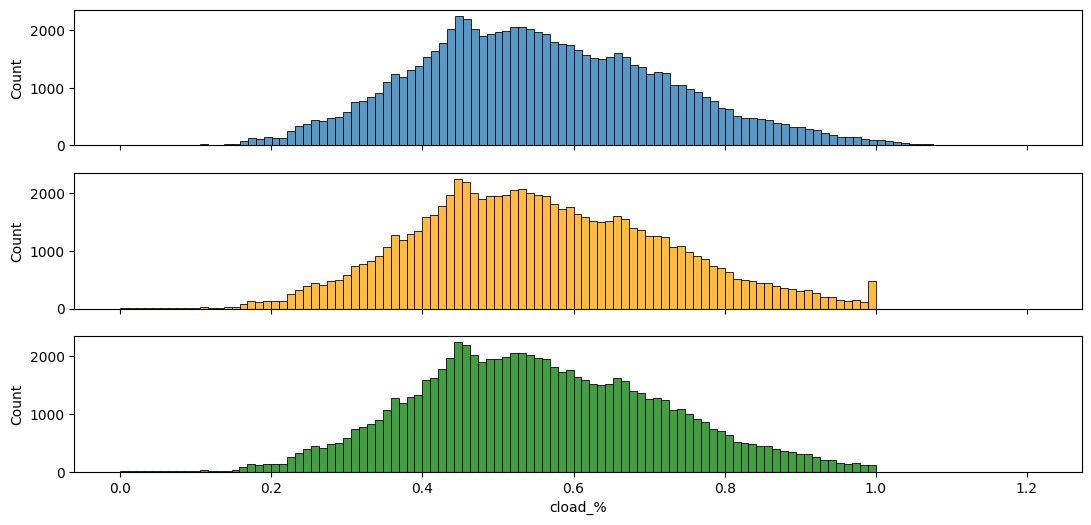

In [7]:
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=[13,6],sharex=True)
# ax.set_xticklabels(ax.get_xticklabels())
dd=d1.copy()
# sometimes there are 6 pumps running for a single chiller !!!
dd['cload']=dd.apply(lambda x: x.fper_ch*x.dT,axis=1)
max_fper_ch=200
dd['full_cload']=max_fper_ch * 5 # 2 pumps running with dT of 5 °C
# dd['full_cload']=300 * 5 # 3 pumps running with dT of 5 °C

# cload      = flow      * cp * dT
# full_cload = max_flow  * cp * max_dT = 300 * cp * 5
dd=dd[dd.fper_ch<=max_fper_ch]
dd['cload_%']=dd.apply(lambda x: x.cload/x.full_cload,axis=1)
dd['cload_%_']=dd.apply(lambda x: min(1,x.cload/x.full_cload),axis=1)

# dd=dd[(dd.sup_temp>=5)&(dd.sup_temp<=11)] # only care when it is running and sup temp is valid
# dd=dd[(dd.ret_temp>=8)&(dd.ret_temp<=15)] # only care when it is running and ret temp is valid

dd=dd[(dd.sup_temp>=6)&(dd.sup_temp<=10)] # only care when it is running and sup temp is valid
dd=dd[(dd.ret_temp>=9)&(dd.ret_temp<=14)] # only care when it is running and ret temp is valid
dd=dd[(dd.ch1_run_sts==1)&(dd.dT>0)] # only care when it is running and dT is real
# dd=dd[dd['cload_%']<=1.00] # remove outliers 
sns.histplot(dd['cload_%'],ax=ax1)
sns.histplot(dd['cload_%_'],color='orange',ax=ax2)
sns.histplot(dd[dd['cload_%']<=1]['cload_%'],color='green',ax=ax3)
# sns.histplot(np.log1p(dd[dd['cload_%']<=1]['cload_%']),color='green',ax=ax3)

<AxesSubplot: >

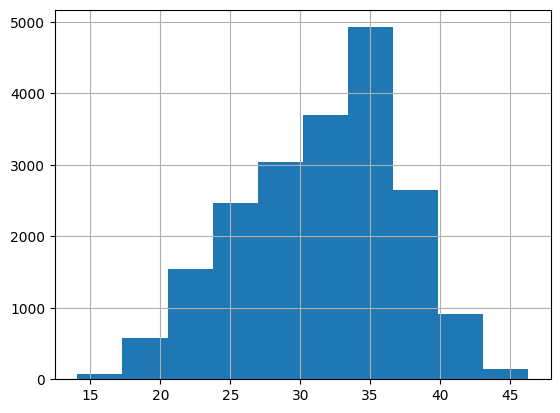

In [8]:
dd.amb_temp.hist()

In [9]:
# analysing when cload >1
dd[dd['cload_%']>1].sort_values('cload_%',ascending=False)
dd[dd['cload_%']>1].sort_values('cload_%',ascending=False).iloc[0]

amb_temp1              35.060000
run_sts                 1.000000
vsd_freq              135.600000
total_kW              138.780000
pp1                    97.920000
pp2                    97.980000
pp3                     0.090000
pp4                    97.970000
pp5                     0.580000
pp6                     2.190000
pp7                    97.900000
pp8                     2.160000
sup_temp                7.170000
ret_temp               13.280000
ch4_total_kW            0.500000
ch2_kW1                58.450000
ch2_kW2               185.250000
ch3_kW1                 0.680000
ch3_kW2                 0.000000
amb_temp                     NaN
run_sts_rounded         1.000000
run_sts_p1rounded       1.000000
ch2kw                 243.700000
ch3kw                   0.680000
ch1_run_sts             1.000000
ch2_run_sts             1.000000
ch3_run_sts             0.000000
ch4_run_sts             0.000000
NR_ch                   2.000000
fper_ch               198.395000
dT        

In [10]:
# sometimes cooling load will be too high but with low kw
dd[(dd['cload_%']>0.9)&(dd.total_kW<70)&(dd.amb_temp>30)].sort_values(by=['total_kW']).reset_index()
# dd[(dd['cload_%']>0.9)&(dd.total_kW<70)&(dd.amb_temp>30)].sort_values(by=['total_kW']).reset_index().iloc[0]


,Timestamp,amb_temp1,run_sts,vsd_freq,total_kW,pp1,pp2,pp3,pp4,pp5,...,ch3_run_sts,ch4_run_sts,NR_ch,fper_ch,dT,t,cload,full_cload,cload_%,cload_%_


### Extra Cleaning and optimizing

In [11]:
ddd=dd.copy()
ddd['month']=pd.to_datetime(ddd.index).month
ddd=ddd[['month','amb_temp']]
# dd[['amb_temp','month']].groupby('month').mean()
# dd.groupby(pd.Grouper(freq='m')).mean().amb_temp
# dd.loc['2020-01-05':'2020-01-31']
# dd[dd.index.to_period('M')=='2020-01']
ddd=ddd.amb_temp.groupby(pd.Grouper(freq='1m')).agg(['count','mean'])
# ddd.columns=ddd.columns.droplevel(2)
ddd['month']=pd.to_datetime(ddd.index).month
tt=ddd.drop('count',axis=1).groupby('month').agg(['mean','std'])
tt.columns=tt.columns.droplevel(0) # to remove first level header

# # maximum standard diviation after that is 1.49 C
ddd[ddd.month==1] # no high standard diviation readings


,count,mean,month
Timestamp,,,
2020-01-31,81,24.295748,1
2021-01-31,35,22.303314,1
2022-01-31,79,23.944928,1
2023-01-31,135,19.361526,1


### visualizing

<AxesSubplot: xlabel='cload_%_', ylabel='total_kW'>

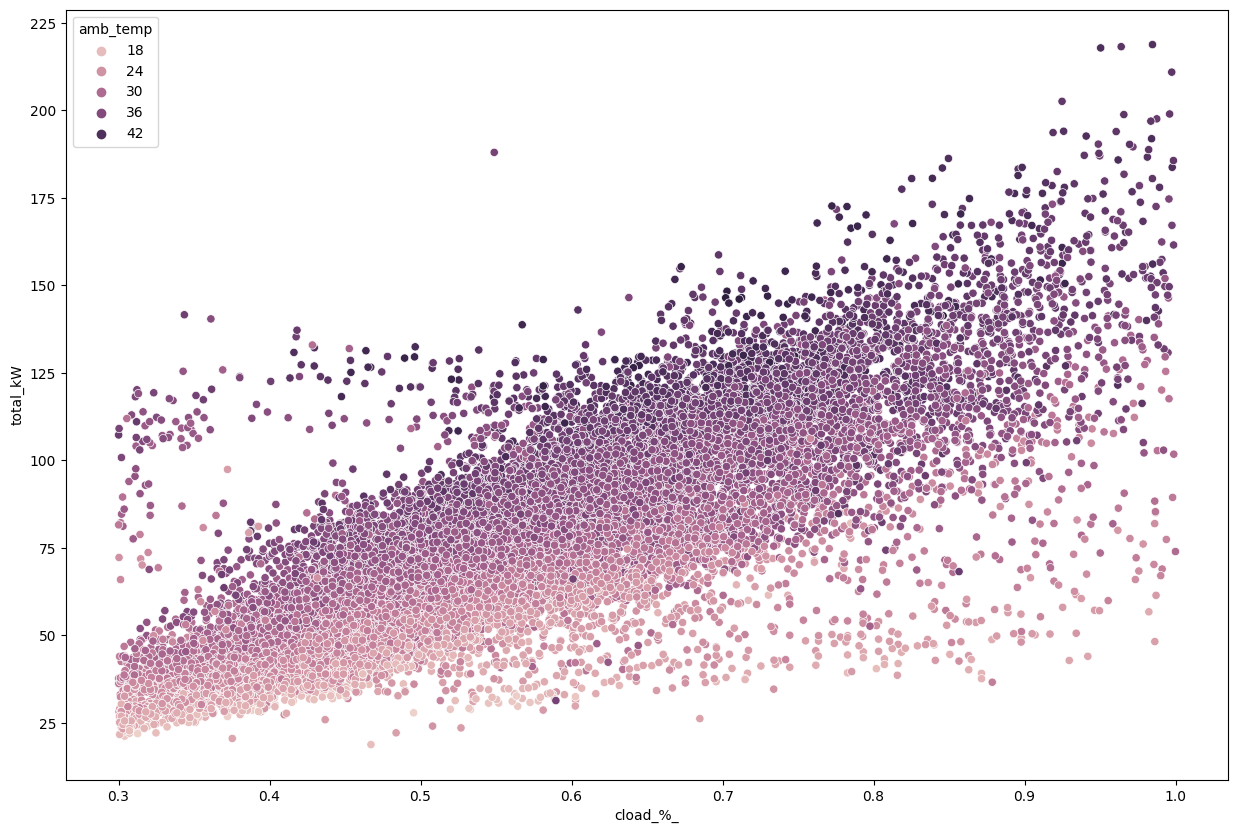

In [12]:
dd=dd[(dd['cload_%']<=1)&(dd['cload_%']>0.3)] # non-vfd limit is 0.3 and vfd limit is 0.1, but we need to compare to non-vfd so we remove <0.3
dd2=dd.copy()
# dd2=dd2.groupby(pd.Grouper(freq='1d')).mean()
fig,ax=plt.subplots(figsize=[15,10])
# dd2.groupby(pd.Grouper(key=dd2.index, freq='1h')).mean()
sns.scatterplot(y=dd2.total_kW,x=dd2['cload_%_'],hue=dd2.amb_temp,ax=ax)

In [13]:
from scipy import interpolate
old=pd.read_csv('Const_spd_screw_ch.csv')
f=interpolate.interp1d(old['capacity%'],old['power%'],fill_value='extrapolate')
max_power=max(dd.total_kW)
dd['old_max_kW']=f(dd['cload_%_'])*max_power
dd['power_%']=dd.apply(lambda x: x.total_kW/x.old_max_kW,axis=1)


<AxesSubplot: >

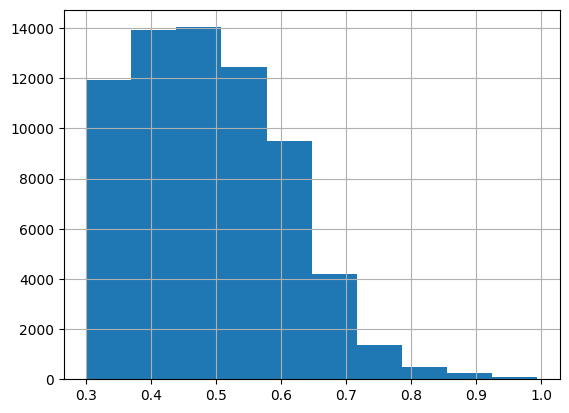

In [14]:
dd[dd['power_%']>1][['amb_temp', 'run_sts', 'vsd_freq', 'total_kW', 'old_max_kW','cload','power_%']]
# dd[dd['power_%']>1].iloc[0] # some cases old chiller perfomred better!!
# dd[dd['power_%']<0.3] # some power is lower than expected limit 
dd=dd[(dd['power_%']<=1)&(dd['power_%']>0.3)]
# dd[dd['fper_ch']<100].fper_ch.hist()
# dd[dd['fper_ch']<100]
dd['power_%'].hist()
# dd

array(0.37)

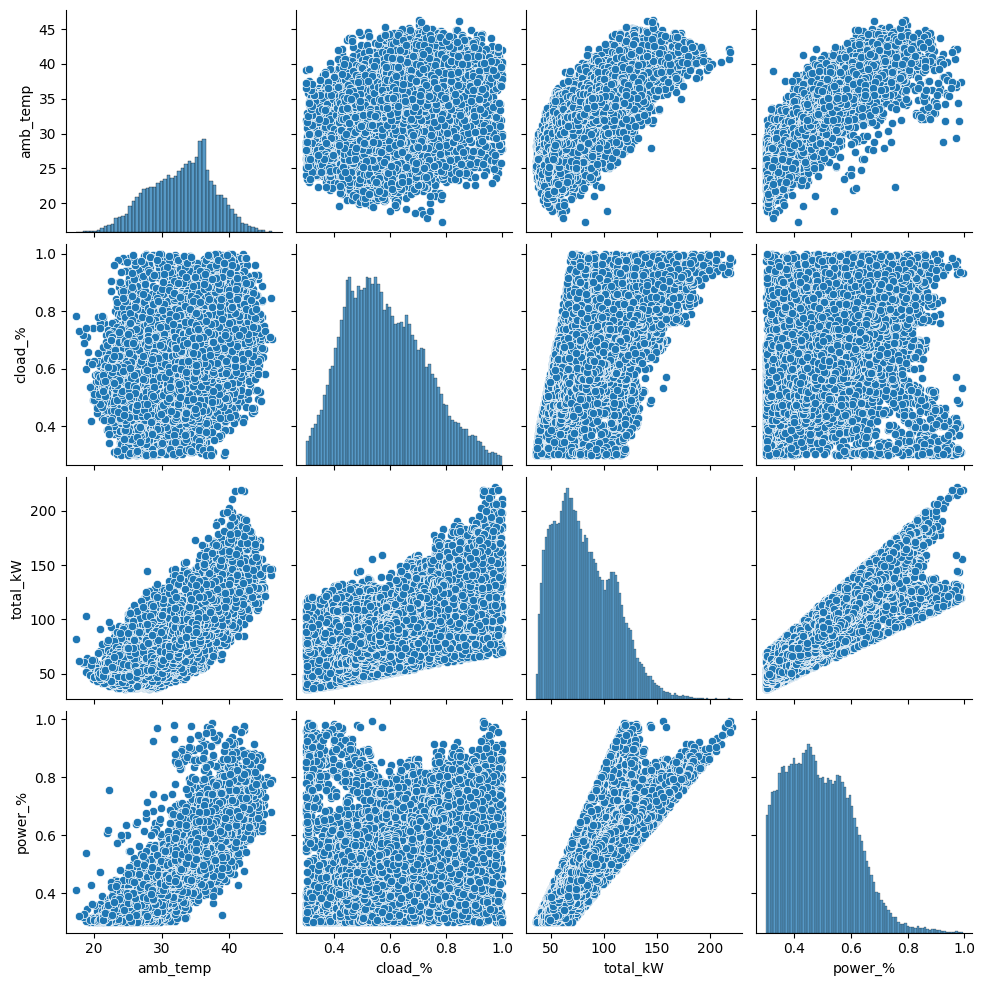

In [15]:

r=dd.copy()
# r= r.drop(['pp1','pp2','pp3','pp4','pp5','pp6','pp7','pp8','ch4_total_kW','ch2_kW1','ch2_kW2','ch3_kW1','ch3_kW2','run_sts', 'vsd_freq'],axis=1)
r=r[['amb_temp','cload_%','total_kW','power_%']]
# max_power=max(r.total_kW)
# old_power=interpolate.interp1d(T_RBH.Tj,T_RBH.kw_TR,fill_value='extrapolate')

# r['power_%']=r.total_kW/max(r.total_kW) # in same month
# r['cload_norm']=np.log1p(r['cload_%'])
sns.pairplot(r)
f(0.0)


### Training the Model

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold,train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# region custom mean squared error metric

import xgboost as xgb
from typing import Tuple
def mse_(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' mean squared error metric.'''
    y = dtrain.get_label()
    
    elements = np.power(y - predt, 2)
    return 'MSE', float(np.sum(elements) / len(y))
def mre_(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' mean relative error metric.'''
    y = dtrain.get_label()
    
    elements = abs(y - predt)/y
    return 'MRE', float(np.sum(elements)/ len(y))
# endregion

X=r[['amb_temp','cload_%']]
# X=r[['amb_temp','cload_norm']]
y=r['power_%']
# y=r['total_kW']

# this is leaking!!!
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [17]:
RFR=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    # ('Scaler',StandardScaler()),
    ('model',RandomForestRegressor())])

# RFR=RandomForestRegressor() # RFR does not support early stopping
RFR.fit(X_train,y_train)
mse=mean_squared_error(y_test,RFR.predict(X_test)) # sum((pred-truth)**2)/len(pred) 
print(f'Random Forest score: {mse}')


Random Forest score: 0.00970618295689197


In [18]:

XGB=XGBRegressor(n_estimators=500,
                learning_rate=0.07,
                max_depth=10,
                random_state=42
                )
# pipeline is meaningless, no need for imputing nor scaling
XGB.fit(X_train,y_train,
        eval_set=[(X_val,y_val)],
        # eval_metric=mse_,
        eval_metric=mre_,
        early_stopping_rounds=10,
        verbose=30)

mse=mean_squared_error(y_test,XGB.predict(X_test)) # sum((pred-truth)**2)/len(pred) 
print(f'XGB MSE: {mse}')


[0]	validation_0-rmse:0.11336	validation_0-MRE:0.20715


[30]	validation_0-rmse:0.08782	validation_0-MRE:0.14065
[60]	validation_0-rmse:0.08751	validation_0-MRE:0.13756
[90]	validation_0-rmse:0.08756	validation_0-MRE:0.13730
[92]	validation_0-rmse:0.08756	validation_0-MRE:0.13730
XGB MSE: 0.0074188541227671


### Model Results

In [19]:
model=RFR
def plotCal(X_test,y_test,h,model,modelname='XGB'):
    tt1=X_test.copy() 
    tt1['pred']=model.predict(X_test)
    tt1['truth']=y_test
    tt1['error']=tt1.apply(lambda x: (x.pred-x.truth)/x.truth,axis=1)
    print('Model\nMAE:',abs(tt1.error).mean())
    ax2=sns.scatterplot(x=tt1.pred,y=tt1.truth,hue=tt1[h])
    ax2.set_title(modelname)
    tt1
    


# my_pp.predict(X_test)
tt1=X_test.copy() 
tt1['pred']=model.predict(X_test)
tt1['truth']=y_test
tt1['error']=tt1.apply(lambda x: (x.pred-x.truth)/x.truth,axis=1)
print('Random Forest results\nError:',abs(tt1.error).mean())
tt1
rr=X_train.copy()
# rr['pred']=model.predict(X_test)
rr['truth']=y_train
# rr['error']=rr.apply(lambda x: (x.pred-x.truth)/x.truth,axis=1)


model2=XGB
tt2=X_test.copy()
tt2['pred']=model2.predict(X_test)
tt2['truth']=y_test
tt2['error']=tt2.apply(lambda x: (x.pred-x.truth)/x.truth,axis=1)
print('XGBoost results\nError:',abs(tt2.error).mean())
tt2


Random Forest results
Error: 0.14850325600124945
XGBoost results
Error: 0.1345690878711312


,amb_temp,cload_%,pred,truth,error
Timestamp,,,,,
2020-03-28 18:30:00,NaN,0.318914,0.381221,0.334745,0.138839
2022-09-21 15:45:00,NaN,0.843285,0.582735,0.621796,-0.062819
2021-09-30 13:30:00,NaN,0.715971,0.561957,0.603253,-0.068456
2023-04-30 23:15:00,NaN,0.580736,0.497991,0.433569,0.148586
2022-05-27 21:45:00,NaN,0.453829,0.430312,0.425288,0.011813
...,...,...,...,...,...
2023-08-10 23:15:00,NaN,0.729816,0.566114,0.597921,-0.053197
2020-03-20 05:30:00,NaN,0.477896,0.432718,0.354585,0.220349
2023-05-15 21:45:00,NaN,0.479740,0.433715,0.436540,-0.006472


In [20]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
@interact(x=True, y=1.0)
def g(x, y):
    return (x, y)

interactive(children=(Checkbox(value=True, description='x'), FloatSlider(value=1.0, description='y', max=3.0, …

Text(0.5, 1.0, 'xgboost')

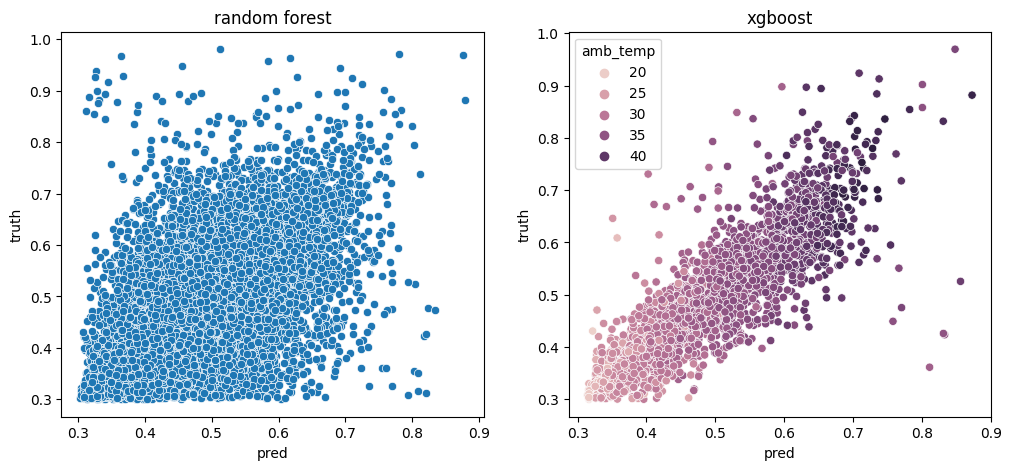

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[12,5])

sns.scatterplot(x=tt1.pred,y=tt1.truth,ax=ax1)
ax1.set_title('random forest')

sns.scatterplot(x=tt2.pred,y=tt2.truth,ax=ax2,hue=tt2.amb_temp)
ax2.set_title('xgboost')
# tt2

In [22]:
tt2['mean_e']=tt2.apply(lambda x: abs(x.pred-x.truth)/x.truth,axis=1)
# mean absolute error is about 9%
# largest error is due to outlaying value
tt2.sort_values('mean_e',ascending=False).iloc[0]
# tt1
tt2.mean_e.mean()

0.1345690878711312

Total_kW at:
amb_temp (34 , 36)
cload_%  (0.27 , 0.32999999999999996)
XGB=0.81, RFR=0.80
0.25826271757907127


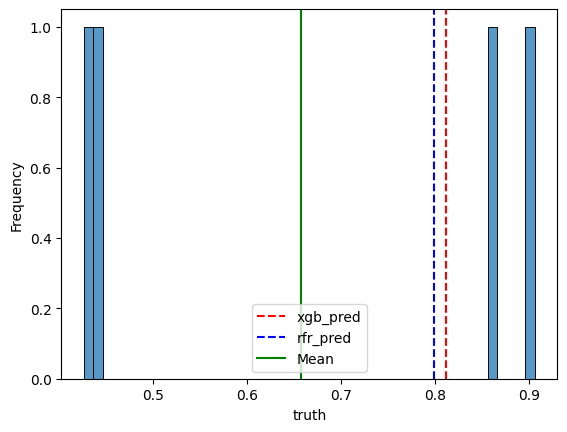

In [23]:
# T,cload=43,0.78
T,cload=43,0.87
T,cload=35,0.3
# T,cload=35,0.6


ts,cs=1,0.03 # temp step, cload step
# ts,cs=.5,0.015 # temp step, cload step

# region calculation
t1,t2=T+ts,T-ts
c1,c2=cload+cs,cload-cs
pred_xgb=XGB.predict(X=np.array([[T,cload]]))[0]
pred_rfr=RFR.predict(X=np.array([[T,cload]]))[0]
# p=dd.copy()

p=tt1.copy() # test data
# p=rr.copy() # training data
# hist_data=p[(p.amb_temp<t1)&(p.amb_temp<t2)&(p['cload_%']<c1)&(p['cload_%']<c2)].total_kW
hist_data=p[(p.amb_temp<t1)&(p.amb_temp>t2)&(p['cload_%']<c1)&(p['cload_%']>c2)].truth

hist_mean=hist_data.mean()
# sns.histplot(hist_data)
print(f'Total_kW at:\namb_temp ({t2} , {t1})\ncload_%  ({c2} , {c1})')
print(f'XGB={pred_xgb:0.2f}, RFR={pred_rfr:0.2f}')

sns.histplot(hist_data,binwidth=0.01)
plt.axvline(x=pred_xgb, color='red', linestyle='--', label='xgb_pred')
plt.axvline(x=pred_rfr, color='blue', linestyle='--', label='rfr_pred')
plt.axvline(x=hist_mean, color='green', linestyle='-', label='Mean')

# plt.xlabel('total_kW')
plt.ylabel('Frequency')
plt.legend()
# plt.title('Histogram of total_kW with Markers')
print(hist_data.std())
# plt.show()
# p[(p.amb_temp<t1)&(p.amb_temp>t2)&(p['cload_%']<c1)&(p['cload_%']>c2)]
# endregion

In [24]:
# ax=sns.histplot(dd.sup_temp,binwidth=0.5)
# ax.set_yscale('log')

### Matrix Generator

In [25]:
dd.amb_temp.max()

46.30625

Text(737.5404040404039, 0.5, 'T')

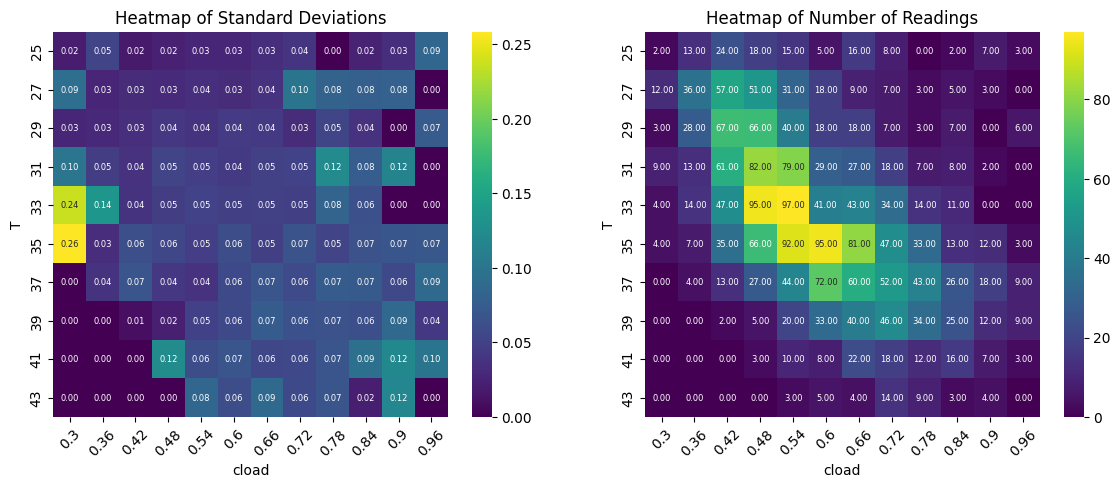

In [26]:
ts,cs=2,0.06
t_=np.arange(25,45,ts)
c_=np.round(np.arange(0.3,1,cs),2)
std_matrix=np.zeros([len(t_),len(c_)])
count_matrix=np.zeros([len(t_),len(c_)])
p=tt2.copy() # test data
fig,(ax1,ax2)=plt.subplots(1,2,figsize=[14,5])
# p=rr.copy() # training data
# hist_data=p[(p.amb_temp<t1)&(p.amb_temp<t2)&(p['cload_%']<c1)&(p['cload_%']<c2)].total_kW
for ti,t in enumerate(t_):
    t1,t2=t+ts/2,t-ts/2
    for ci,c in enumerate(c_):
        c1,c2=c+cs/2,c-cs/2
        val=p[(p.amb_temp<t1)&(p.amb_temp>t2)&(p['cload_%']<c1)&(p['cload_%']>c2)].truth
        count_=val.count()
        if count_<2:
            continue
        count_matrix[ti,ci]=val.count()
        std_matrix[ti,ci]=val.std()
std_df = pd.DataFrame(std_matrix, index=t_, columns=c_)
cnt_df = pd.DataFrame(count_matrix, index=t_, columns=c_)
# plt.figure(figsize=(12, 7))
sns.heatmap(std_df, cmap='viridis', annot=True, fmt=".2f",annot_kws={"size": 6},ax=ax1)
sns.heatmap(cnt_df, cmap='viridis', annot=True, fmt=".2f",annot_kws={"size": 6},ax=ax2)
ax1.set_title('Heatmap of Standard Deviations')
ax2.set_title('Heatmap of Number of Readings')

ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_xlabel('cload')
ax1.set_ylabel('T')

ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_xlabel('cload')
ax2.set_ylabel('T')
# ax1.show()

Text(0.5, 1.0, 'xgboost')

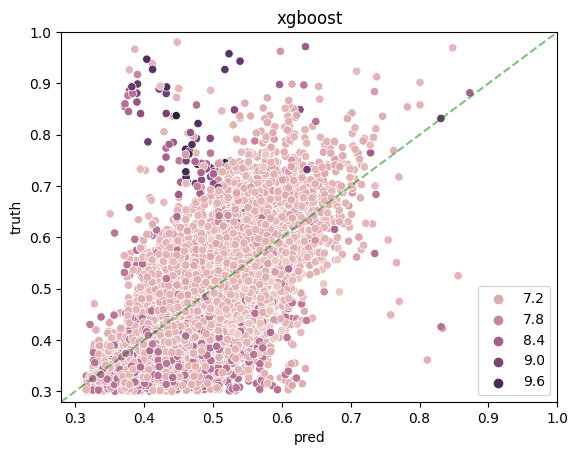

In [27]:
dd.columns
t=tt2.copy()
# dd=dd[['amb_temp', 'vsd_freq', 'total_kW', 'sup_temp', 'ret_temp',
#        'NR_ch', 'fper_ch', 'dT']]
t['timestamp']=t.index
t=t.merge(dd)
"""['amb_temp', 'cload_%', 'pred', 'truth', 'error', 'timestamp', 'run_sts',
       'vsd_freq', 'total_kW', 'pp1', 'pp2', 'pp3', 'pp4', 'pp5', 'pp6', 'pp7',
       'pp8', 'sup_temp', 'ret_temp', 'ch4_total_kW', 'ch2_kW1', 'ch2_kW2',
       'ch3_kW1', 'ch3_kW2', 'run_sts_rounded', 'run_sts_p1rounded', 'ch2kw',
       'ch3kw', 'ch1_run_sts', 'ch2_run_sts', 'ch3_run_sts', 'ch4_run_sts',
       'NR_ch', 'fper_ch', 'dT', 'full_cload', 'cload', 'cload_%_', 'month']""" 
ax2=sns.scatterplot(x=t.pred,y=t.truth,hue=t.sup_temp) # at 10 C outliers
# ax2=sns.scatterplot(x=t.pred,y=t.truth,hue=t.amb_temp) # at 10 C outliers
# ax2=sns.scatterplot(x=t.pred,y=t.truth,hue=t.ret_temp) # higher is worse
# ax2=sns.scatterplot(x=t.pred,y=t.truth,hue=t.fper_ch) # higher is worse
# ax2=sns.scatterplot(x=t.pred,y=t.truth,hue=t.dT) # no effect
# ax2=sns.scatterplot(x=t.pred,y=t.truth,hue=t.dT) # no effect
sns.lineplot(x=[0,1],y=[0,1],linestyle="dashed", color="green",alpha=0.5,legend='full',ax=ax2)
ax2.set_xlim([0.28,1])
ax2.set_ylim([0.28,1])
# ax2.annotate('', xy=(0, 0), xytext=(10, 10), arrowprops=dict(arrowstyle='-'))
# ax2=sns.scatterplot(x=t.pred,y=t.truth,hue=t.vsd_freq) # when higher vsd, power will be higher than predicted

ax2.set_title('xgboost')
# t.columns
# t[t['fper_ch']>290]

In [28]:
tt_month=tt1.groupby(pd.Grouper(freq='1m')).mean().drop(['error'],axis=1).dropna(axis=0)
tt_month['mean_e']=tt_month.apply(lambda x: abs(x.pred-x.truth)/x.truth,axis=1)
print(tt_month.mean_e.mean())
tt_month.head(8)

0.10886653889430822


,amb_temp,cload_%,pred,truth,mean_e
Timestamp,,,,,
2019-10-31,32.489731,0.562092,0.476719,0.483018,0.013040
2019-11-30,28.401014,0.464807,0.412069,0.406153,0.014568
2020-01-31,25.811250,0.643921,0.483255,0.380085,0.271439
2020-02-29,25.132067,0.659153,0.490109,0.377203,0.299323
2020-03-31,27.188360,0.502580,0.414480,0.374593,0.106482
2020-04-30,31.102124,0.423773,0.420883,0.415561,0.012807
2020-05-31,32.600920,0.611832,0.504151,0.500872,0.006546
2020-06-30,35.016370,0.582169,0.504372,0.551455,0.085378


### Aggregate readings per (n hours) 

In [29]:
fr=['15min','30min','1h','2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h','24h']
n=[1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
dictt=pd.DataFrame(columns=['XGB_Error','RFR_Error'])
if len(n)!=len(fr):
        print('n != fr !!!!')
for i,f in enumerate(fr):
    countlim=n[i] # every hour is 4
    count_= X.amb_temp.groupby(pd.Grouper(freq=f)).agg(['count'])
    count_id=count_[count_['count']>=countlim].index
    count_id
    X_=X.groupby(pd.Grouper(freq=f)).mean().loc[count_id]
    y_=y.groupby(pd.Grouper(freq=f)).mean().loc[count_id]
    # this is leaky:
#     X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    X_train, X_temp, y_train, y_temp = train_test_split(X_, y_, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


    XGB=XGBRegressor(n_estimators=500,
            learning_rate=0.07,
            max_depth=10,
            random_state=42
            )
    XGB.fit(X_train,y_train,
        eval_set=[(X_val,y_val)],
        # eval_metric=mse_,
        eval_metric=mre_,
        early_stopping_rounds=10,
        verbose=False)
    # pipeline is meaningless, no need for imputing nor scaling
    RFR.fit(X_train,y_train)
    ttp=X_test.copy()
    ttp['truth']=y_test
    ttp['pred_XGB']=XGB.predict(X_test)
    ttp['error_XGB']=ttp.apply(lambda x: (x.pred_XGB-x.truth)/x.truth,axis=1)
    ttp['pred_RFR']=RFR.predict(X_test)
    ttp['error_RFR']=ttp.apply(lambda x: (x.pred_RFR-x.truth)/x.truth,axis=1)
    e_XGB=np.round(abs(ttp.error_XGB).mean(),3)
    e_RFR=np.round(abs(ttp.error_RFR).mean(),3)
    dictt.loc[f,'XGB_Error']=e_XGB
    dictt.loc[f,'RFR_Error']=e_RFR
    print('freq: ',f,', train: ',len(X_train),', test: ',len(X_test) ,'====>',e_XGB,e_RFR)

freq:  15min , train:  11948 , test:  2560 ====> 0.082 0.086
freq:  30min , train:  11948 , test:  2560 ====> 0.08 0.085
freq:  1h , train:  11948 , test:  2560 ====> 0.076 0.08
freq:  2h , train:  5572 , test:  1194 ====> 0.069 0.071
freq:  3h , train:  3504 , test:  751 ====> 0.068 0.069
freq:  4h , train:  2487 , test:  533 ====> 0.065 0.066
freq:  5h , train:  1899 , test:  407 ====> 0.068 0.068
freq:  6h , train:  1491 , test:  320 ====> 0.071 0.068
freq:  7h , train:  1236 , test:  265 ====> 0.069 0.065
freq:  8h , train:  1007 , test:  216 ====> 0.068 0.065
freq:  9h , train:  863 , test:  185 ====> 0.065 0.063
freq:  10h , train:  753 , test:  162 ====> 0.061 0.057
freq:  11h , train:  658 , test:  141 ====> 0.064 0.058
freq:  12h , train:  573 , test:  123 ====> 0.064 0.064
freq:  13h , train:  511 , test:  109 ====> 0.063 0.064
freq:  14h , train:  460 , test:  99 ====> 0.065 0.064
freq:  15h , train:  411 , test:  88 ====> 0.055 0.056
freq:  16h , train:  373 , test:  80 ===

In [30]:
dicto=pd.DataFrame(columns=['XGB_Error','RFR_Error'])
dicto.loc['cat','XGB_Error']=10


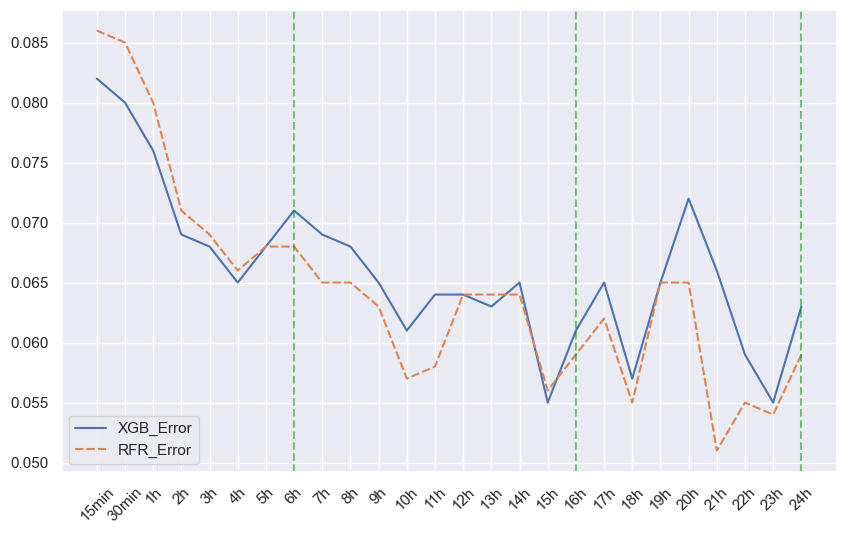

In [31]:
sns.set_theme()
plt.figure(figsize=(10, 6)) 
ax=sns.lineplot(dictt)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
parms={'color':'green', 'linestyle':'--','alpha':0.5}
plt.axvline('6h',**parms)
plt.axvline('16h',**parms)
plt.axvline('24h',**parms)

 

In [32]:
# 15 - 19, 15:15 - 19:15 moving window (4 hrs in middle)

# ambient temperature

# use new model if good on ch4 and other building

### Aggregating training data over ±n hours (moving window)

In [33]:
from datetime import timedelta
r2=r[['amb_temp','cload_%','power_%']]
# r2.loc['2019-10-03 11:45:00':'2019-10-03 15:45:00']
def ag(row,r2):
    n=1  # Number of hours to ±
    i=row.name
    im2=i-timedelta(hours=n)
    ip2=i+timedelta(hours=n)
    d=r2.loc[im2:ip2].mean()
    # print(d)
    return d
r3=r2.apply(lambda x:ag(x,r2),axis=1)

# note that aggregation was done on period where run=true


<AxesSubplot: xlabel='Timestamp', ylabel='power_%'>

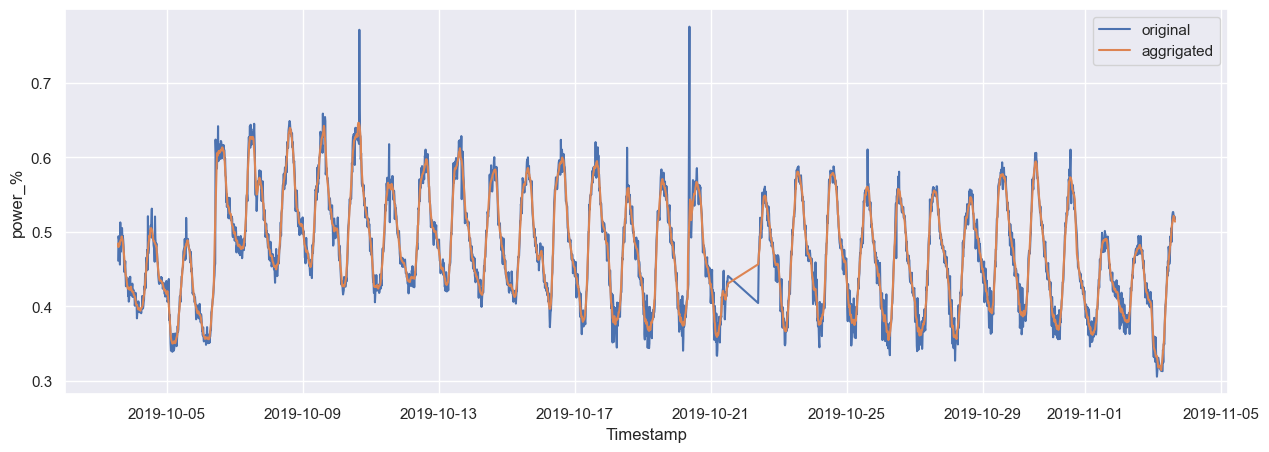

In [34]:
plt.figure(figsize=[15,5])

sns.lineplot(r2.loc['2019-10-03 11:45:00':'2019-11-03 15:45:00']['power_%'],label='original')
sns.lineplot(r3.loc['2019-10-03 11:45:00':'2019-11-03 15:45:00']['power_%'],label='aggrigated')


In [35]:
r3.columns

Index(['amb_temp', 'cload_%', 'power_%'], dtype='object')

In [36]:
X_3=r3.copy()
y_3=X_3.pop('power_%')

X_train, X_temp, y_train, y_temp = train_test_split(X_3, y_3, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


XGB=XGBRegressor(n_estimators=500,
        learning_rate=0.07,
        max_depth=10,
        random_state=42
        )
XGB.fit(X_train,y_train,
    eval_set=[(X_val,y_val)],
    # eval_metric=mse_,
    eval_metric=mre_,
    early_stopping_rounds=10,
    verbose=15)
# pipeline is meaningless, no need for imputing nor scaling
RFR.fit(X_train,y_train)
ttp=X_test.copy()
ttp['truth']=y_test
ttp['pred_XGB']=XGB.predict(X_test)
ttp['error_XGB']=ttp.apply(lambda x: (x.pred_XGB-x.truth)/x.truth,axis=1)
ttp['pred_RFR']=RFR.predict(X_test)
ttp['error_RFR']=ttp.apply(lambda x: (x.pred_RFR-x.truth)/x.truth,axis=1)
e_XGB=np.round(abs(ttp.error_XGB).mean(),3)
e_RFR=np.round(abs(ttp.error_RFR).mean(),3)
# dictt.loc[f,'XGB_Error']=e_XGB
# dictt.loc[f,'RFR_Error']=e_RFR
print('train: ',len(X_train),', test: ',len(X_test) ,'====>',e_XGB,e_RFR)

[0]	validation_0-rmse:0.10654	validation_0-MRE:0.19568
[15]	validation_0-rmse:0.05809	validation_0-MRE:0.09602
[30]	validation_0-rmse:0.04898	validation_0-MRE:0.07316
[45]	validation_0-rmse:0.04743	validation_0-MRE:0.06869
[60]	validation_0-rmse:0.04696	validation_0-MRE:0.06752
[75]	validation_0-rmse:0.04675	validation_0-MRE:0.06709
[90]	validation_0-rmse:0.04667	validation_0-MRE:0.06692
[105]	validation_0-rmse:0.04662	validation_0-MRE:0.06679
[120]	validation_0-rmse:0.04659	validation_0-MRE:0.06671
[135]	validation_0-rmse:0.04656	validation_0-MRE:0.06662
[150]	validation_0-rmse:0.04651	validation_0-MRE:0.06653
[165]	validation_0-rmse:0.04646	validation_0-MRE:0.06643
[180]	validation_0-rmse:0.04642	validation_0-MRE:0.06635
[195]	validation_0-rmse:0.04641	validation_0-MRE:0.06632
[210]	validation_0-rmse:0.04639	validation_0-MRE:0.06629
[225]	validation_0-rmse:0.04639	validation_0-MRE:0.06627
[240]	validation_0-rmse:0.04637	validation_0-MRE:0.06623
[255]	validation_0-rmse:0.04635	validat

In [37]:
# import pickle
# with open('models/XGB_a_2.pkl','wb') as f:
#     pickle.dump(XGB,f)
    

In [38]:
# aggregate hourly mean()
# add temp from site
# compare with underground weather data hourly
# aggregate of ±1 hour
# train model


In [39]:
dd

,amb_temp1,run_sts,vsd_freq,total_kW,pp1,pp2,pp3,pp4,pp5,pp6,...,NR_ch,fper_ch,dT,t,cload,full_cload,cload_%,cload_%_,old_max_kW,power_%
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-10-03 13:45:00,36.11,1.0,96.1,92.88,81.42,0.13,81.38,81.09,81.49,0.60,...,2,163.645,4.89,NaN,800.22405,1000,0.800224,0.800224,201.340406,0.461308
2019-10-03 14:00:00,36.72,1.0,115.7,111.33,81.43,0.12,81.39,81.09,81.48,0.60,...,2,163.660,5.88,36.10500,962.32080,1000,0.962321,0.962321,225.286987,0.494170
2019-10-03 14:15:00,36.22,1.0,118.8,109.83,81.43,0.10,81.39,81.08,81.47,0.60,...,2,163.640,5.83,NaN,954.02120,1000,0.954021,0.954021,223.942676,0.490438
2019-10-03 14:30:00,36.00,1.0,112.3,111.33,81.45,0.10,81.40,81.14,81.48,0.61,...,2,163.695,5.95,NaN,973.98525,1000,0.973985,0.973985,227.176313,0.490060
2019-10-03 14:45:00,36.06,1.0,112.0,109.43,81.42,0.10,81.43,81.06,81.50,0.59,...,2,163.645,5.89,NaN,963.86905,1000,0.963869,0.963869,225.537762,0.485196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-21 07:15:00,33.76,1.0,97.2,84.91,71.33,71.46,71.52,0.88,0.92,0.95,...,2,144.490,4.23,NaN,611.19270,1000,0.611193,0.611193,170.727615,0.497342
2023-08-21 07:30:00,33.96,1.0,101.3,87.49,71.33,71.46,71.52,0.88,0.92,0.95,...,2,144.490,4.36,NaN,629.97640,1000,0.629976,0.629976,173.770067,0.503481
2023-08-21 07:45:00,33.93,1.0,102.3,90.48,71.33,71.46,71.52,0.88,0.92,0.95,...,2,144.490,4.36,NaN,629.97640,1000,0.629976,0.629976,173.770067,0.520688
